# Machine Learning in Python
Machine Learning is the study and application of algorithms that generate statistic models that are able to perform a specific task without being specifically coded. Models are created by observing a set of samples and extracting and learning the patterns in the samples data.

The most used library in Python to work with ML is SciKit-Learn https://scikit-learn.org/stable/. This module includes the implementations of dozens of different ML algorithms and the functions needed to handle and transform the data that will be used by the ML models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

The next cell downloads the required data set to carry out the workshop. This kind of code only works on Google Colab, and if you are using another platform to run the notebook, you will need to manually download the data directory from the GitHub repository and put it in the same path as the notebook file.

In [2]:
!wget -O main.zip https://github.com/jandion/APSV-BusinessIntelligence/archive/refs/heads/main.zip
!unzip main.zip
!rm -rf data
!mv APSV-BusinessIntelligence-main/data .
!rm -r APSV-BusinessIntelligence-main main.zip

--2022-12-19 10:35:45--  https://github.com/jandion/APSV-BusinessIntelligence/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/jandion/APSV-BusinessIntelligence/zip/refs/heads/main [following]
--2022-12-19 10:35:45--  https://codeload.github.com/jandion/APSV-BusinessIntelligence/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [  <=>               ]  14.96M  12.6MB/s    in 1.2s    

2022-12-19 10:35:47 (12.6 MB/s) - ‘main.zip’ saved [15691344]

Archive:  main.zip
4cabea09456a143b49ce229fb224416d607235d4
   creating: APSV-BusinessIntelligence-main/


If you have any problem importing those modules, you might need to install or update them. If you are using Anaconda, run an Anaconda Prompt and execute `conda install [package]`, or, if you are using just Python, open a terminal and execute `pip install [package]`.

Let's load our well known dataset of train events:

In [3]:
import pandas as pd
data = pd.read_csv("data/trains.zip").dropna()
data.sheduled_date = data.sheduled_date.astype("datetime64[ns]")
data.actual_date = data.actual_date.astype("datetime64[ns]")

We are going to transform this train event data set into a table in which each row contains the information for a single train trip. These rows will indicate the number of packages that were transported on the train, the number of wagons that were used, the delay in loading and unloading packages, the customer, the train used and the destination station.

The code used below includes some advanced functions, such as the `pivot` method. It is not necessary to understand exactly what is happening, but it is advisable to try to analyze it.

In [5]:
#Keep only relevant events
trains = data[data.event_type.isin(["LLEGADA A DESTINO DE VAGONES", "SALIDA DE VAGONES"])]

#Calculate delays of each event (in seconds)
trains.loc[:,"delay"] = (trains.actual_date - trains.sheduled_date).dt.total_seconds()
trains = trains.drop(columns=["Unnamed: 0", "container_type", "origin", "destination", "estimated_date", "actual_date"])


#Pivot the table to create columns with the delay of each event type
pivot_event=trains.pivot(columns=["event_type"],values=["delay"])
pivot_event.columns=pivot_event.columns.map(lambda x: x[0]+"_"+x[1].split(" ")[0])
trains = trains.join(pivot_event)

#Removing unwanted values
trains.loc[trains.event_type=="SALIDA DE VAGONES", "event_location"] = np.NaN
trains.loc[trains.event_type=="LLEGADA A DESTINO DE VAGONES", "sheduled_date"] = np.NaN
#Mixing duplicated rows keeping not null values
trains = trains.drop(columns = ["event_type", "delay"]).groupby(["item_id","container_id","client","train_id"],as_index=False).first()

#Grouping by train trip, counting the number of packages and waggons
trains = trains.groupby("sheduled_date",as_index=False).agg({"item_id":"nunique", "container_id":"nunique", "client":"first", "train_id":"first", "event_location":"first", "delay_LLEGADA":"mean", "delay_SALIDA":"mean"})

#Renaming the final columns
trains = trains.drop(columns=["sheduled_date"]).rename(columns={"item_id":"packages", "container_id":"waggons"}).dropna()

trains


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,packages,waggons,client,train_id,event_location,delay_LLEGADA,delay_SALIDA
0,240,28,CLIENT_2,TRAIN 4,STATION 8,65940.0,181380.000000
1,192,17,CLIENT_1,TRAIN 2,STATION 5,72600.0,-21540.000000
2,248,31,CLIENT_2,TRAIN 4,STATION 8,68040.0,179280.000000
3,217,31,CLIENT_1,TRAIN 5,STATION 9,61500.0,55500.000000
4,238,17,CLIENT_2,TRAIN 3,STATION 1,86400.0,173940.000000
...,...,...,...,...,...,...,...
1954,205,18,CLIENT_3,TRAIN 2,STATION 5,83520.0,-63579.512195
1955,186,31,CLIENT_2,TRAIN 4,STATION 8,-16620.0,16200.000000
1956,187,17,CLIENT_3,TRAIN 2,STATION 5,77880.0,-25740.000000
1957,238,17,CLIENT_2,TRAIN 3,STATION 1,69600.0,71400.000000


Most ML algorithms can only work with numerical values, therefore, we have to convert the columns that contain text (categorical variables) into numbers. The simplest way to do this is by using a LabelEncoder, which just assigns each category to which it finds an integer.

In [6]:
from sklearn import preprocessing
client_encoder = preprocessing.LabelEncoder().fit(trains.client.unique())
train_encoder = preprocessing.LabelEncoder().fit(trains.train_id.unique())
location_encoder = preprocessing.LabelEncoder().fit(trains.event_location.unique())

for i in range(len(client_encoder.classes_)):
    print(f"""{client_encoder.classes_[i]} encoded as {i}""")
for i in range(len(train_encoder.classes_)):
    print(f"""{train_encoder.classes_[i]} encoded as {i}""")
for i in range(len(location_encoder.classes_)):
    print(f"""{location_encoder.classes_[i]} encoded as {i}""")

trains.client = pd.Series(client_encoder.transform(trains.client.values), index = trains.index)
trains.train_id = pd.Series(train_encoder.transform(trains.train_id.values), index = trains.index)
trains.event_location = pd.Series(location_encoder.transform(trains.event_location.values), index = trains.index)

CLIENT_0 encoded as 0
CLIENT_1 encoded as 1
CLIENT_2 encoded as 2
CLIENT_3 encoded as 3
CLIENT_4 encoded as 4
TRAIN 0 encoded as 0
TRAIN 1 encoded as 1
TRAIN 2 encoded as 2
TRAIN 3 encoded as 3
TRAIN 4 encoded as 4
TRAIN 5 encoded as 5
TRAIN 6 encoded as 6
TRAIN 7 encoded as 7
TRAIN 8 encoded as 8
TRAIN 9 encoded as 9
STATION 1 encoded as 0
STATION 2 encoded as 1
STATION 5 encoded as 2
STATION 8 encoded as 3
STATION 9 encoded as 4


Some of the calculations perfomed in this notebook could be complex and too heavy for some computers. If your computer takes too long to run the experiments, you can reduce the datasets by executing the following code (uncomment it).

In [ ]:
# With this method we take sample of a dataset, the parameter frac indicates the percentage of the original data we keep
#trains = trains.sample(frac=0.5)

### Train and test
The main idea behind machine learning is that the algorithm will observe a training set of samples, which we should be sure to be representative of the data with which we are working with which. From this training set or training data, the algorithm will learn the patterns that describe the data and generates a model which can replicate the behavior shown on them. Then, using a *different* set of samples, which we call test set or test data, we will evaluate how accurate is the generated model, basically, by measuring the difference between the model output and the correct answer. It is very important to do not use the same data to train and test the model.

Let’s see it with an example.
We will use a popular dataset in ML called iris dataset. This dataset contains a series of measures of flowers and the type of the flower (for more info, check https://archive.ics.uci.edu/ml/datasets/iris). As we will see later, the task of the model we are going to create is a classification task. 
The dataset is made up of observations that contain 4 numeric variables and 1 categorical target. The task of the model is to predict the target of a sample by observing its numeric variables.


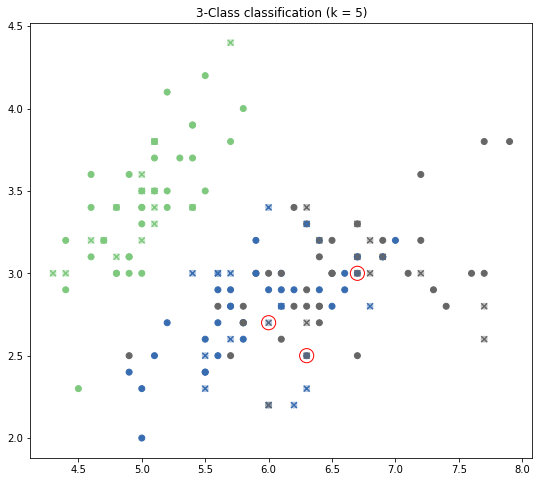

Model accuracy: 93.33%


In [7]:
# This example is based on one example from the scikit learn documentation 
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
from sklearn import neighbors, datasets
from sklearn import model_selection

n_neighbors = 5

iris = datasets.load_iris()

# In this notebook, we will always use x as the feature vector and y as the target
X = iris.data
y = iris.target

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size= 0.3)

clf = neighbors.KNeighborsClassifier(n_neighbors)
clf.fit(x_train, y_train)
y_out = clf.predict(x_test)

fig,ax = plt.subplots(figsize=(9, 8))
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap="Accent")
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_out, cmap="Accent", marker = "x")
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap="Accent", alpha=0.3)
ax.scatter(x_test[y_out != y_test, 0], x_test[y_out != y_test, 1], facecolors='none', edgecolors='r', s=200)

ax.set_title("3-Class classification (k = %i)" % (n_neighbors))
plt.show()

print("Model accuracy: {:.2f}%".format(np.average(y_out==y_test)*100))

Although the dataset has 4 dimensions, the plot only shows 2 dimensions, which is easier for humans. The colors in the plot are the different types of flowers. Dots are the training data and cross the test data, the background of each test sample is the correct type, and the sample is surrounded with a red circle if it was misclasified. The accuracy is just the average of the correct classifications made by the model.

### K-Fold Cross-Validation
Ensure that the partition of the data used to train the model is representative may not be an easy task. For example, in the previous dataset it could be that the data we select to train don't contain samples of one of the class, or may be that the test data were particularly easy to classify.

Cross Validation is a group of techniques that solve this problem, all of them are based on the idea of performing several trainings and testings using different partitions each time. The most basic, and most popular, is the K-Fold Cross Validation.
In K-Fold, we choose a number k (usually from 5 to 10), then we divide our dataset into k folds. We will train the model k times, in each iteration we will use k-1 folds as the train data and the remaining fold as test data. The evaluation of the final model is calculated as the average of the evaluations for each iteration.

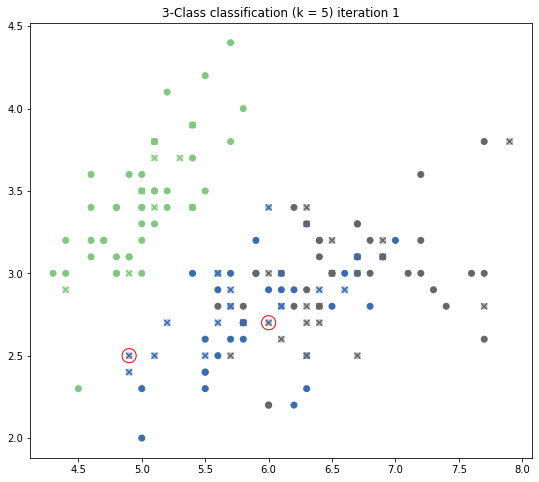

Iteration 1: Model accuracy: 96.00%
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


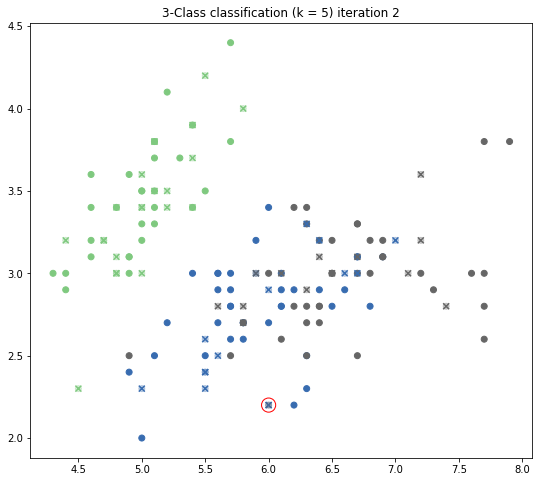

Iteration 2: Model accuracy: 98.00%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 1 2 2 2 2 2 2 2 2 2]


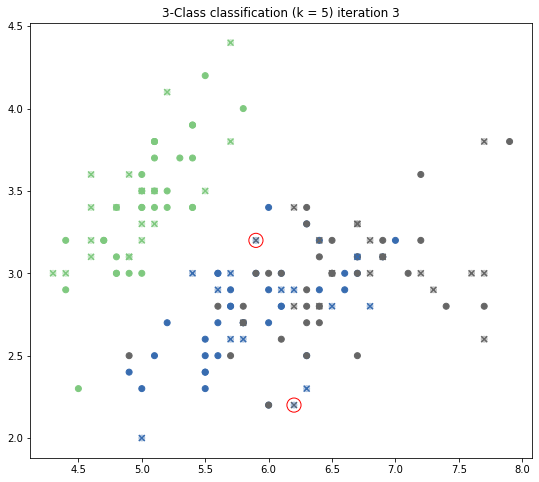

Iteration 3: Model accuracy: 96.00%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]
Global accuracy: 96.67%


In [8]:
from sklearn.model_selection import KFold
k = 3
kf = KFold(n_splits=k,shuffle=True)
accuracies = []
i=0
for train, test in kf.split(X): # train and test are the indices of the samples that will be used in each set
    i+=1
    x_train, x_test, y_train, y_test = X[train], X[test], y[train], y[test]
    clf = neighbors.KNeighborsClassifier(n_neighbors)
    clf.fit(x_train, y_train)
    y_out = clf.predict(x_test)


    fig,ax = plt.subplots(figsize=(9, 8))
    ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap="Accent")
    ax.scatter(x_test[:, 0], x_test[:, 1], c=y_out, cmap="Accent", marker = "x")
    ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap="Accent", alpha=0.3)
    ax.scatter(x_test[y_out != y_test, 0], x_test[y_out != y_test, 1], facecolors='none', edgecolors='r', s=200)
    ax.set_title("3-Class classification (k = %i) iteration %i" % (n_neighbors,i))
    plt.show()
    accuracy = np.average(y_out==y_test)*100
    accuracies.append(accuracy)
    print("Iteration {}: Model accuracy: {:.2f}%".format(i,accuracy))
    print(y_test)
    print(y_out)
print("Global accuracy: {:.2f}%".format(np.average(accuracies)))

## Regression
Regression is one of the possible tasks for an ML model. The objective is to predict a numeric output based on the input. One example of this could be to predict the number of products that will be sold based on the previous sales or calculate the probability that the stock market will grow tomorrow.


The most basic example of this task is to obtain the relation between two variables.

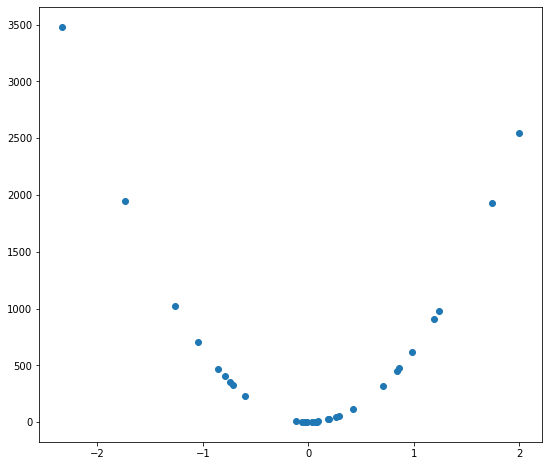

In [18]:
from sklearn import datasets
import math

x, y = datasets.make_regression(n_samples=30, n_features=1, noise=0)
# try to modify the relation between x and y or play with the noise value
y = y**2
#y = np.sin(y)
fig,ax = plt.subplots(figsize=(9, 8))
ax.scatter(x, y)
plt.show()

Problems in the real world are more complicated, the target (variable we want to predict) usually depends on more variables (features).

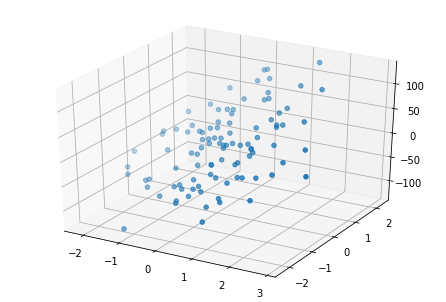

In [19]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
x, y = datasets.make_regression(n_samples=100, n_features=2, noise= 0)
ax.scatter(x[:,0], x[:,1],y)
plt.show()

#### Optional extra
Try to plot the iris dataset in a 3d plot

### Some popular models
There are many different algorithms or models that can be used for regression tasks. Each of them has its advantages or disadvantages for each kind of problem, but to discuss them is far beyond the scope of this course. We will just try them with their basic configuration and keep the one that best fits our case.

#### Linear regression
This is the most basic regression model. The algorithm will just try to minimize the error in a function like $Y=aX+b$, where $Y$ is the target and $X$ the vector of features.

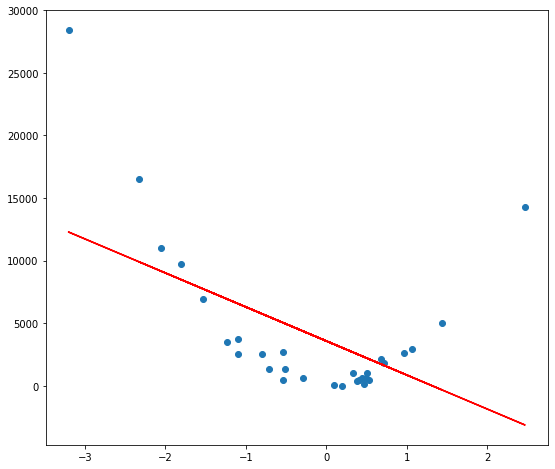

In [21]:
from sklearn.linear_model import LinearRegression
x, y = datasets.make_regression(n_samples=30, n_features=1, noise=10)

y=y**2
model = LinearRegression().fit(x,y)
fig,ax = plt.subplots(figsize=(9, 8))
ax.scatter(x, y)
ax.plot(x,model.predict(x), "r")
plt.show()

#### Decision Tree
This model is based on a tree structure in which each node represents a decision and each leaf an output. https://en.wikipedia.org/wiki/Decision_tree

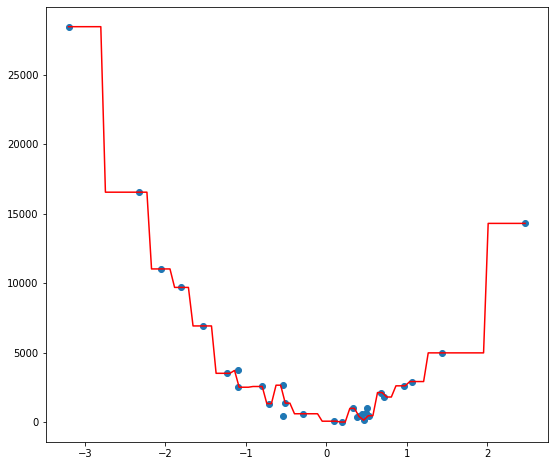

In [22]:
from sklearn.tree import DecisionTreeRegressor
x_test= np.linspace(x.min(),x.max(), 100)[:, np.newaxis]

model = DecisionTreeRegressor().fit(x,y)
fig,ax = plt.subplots(figsize=(9, 8))
ax.scatter(x, y)
ax.plot(x_test ,model.predict(x_test),"r")

plt.show()

#### Random Forest
This model belongs to a category called ensemble models, because it is made of the aggregation of several models. In the case of random forest, we will have a set of decision trees which will calculate an output, then the output of the random forest will be the average of those outputs.

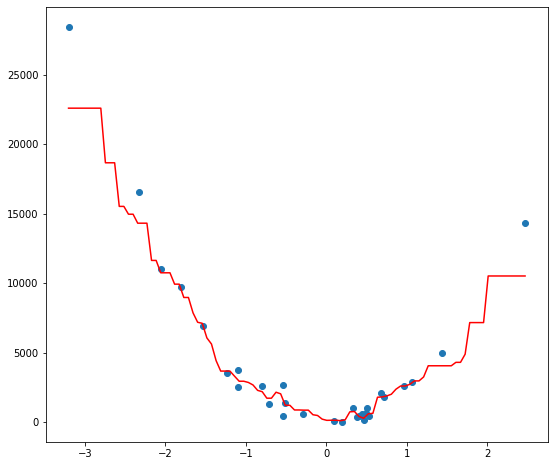

In [23]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100).fit(x,y)
plt.figure(figsize=(9, 8))
plt.scatter(x, y)
plt.plot(x_test ,model.predict(x_test), "r")
plt.show()

#### K Nearest Neighbors
Given an input, the output of this algorithm will be the average of the $k$ nearest points in the training set.

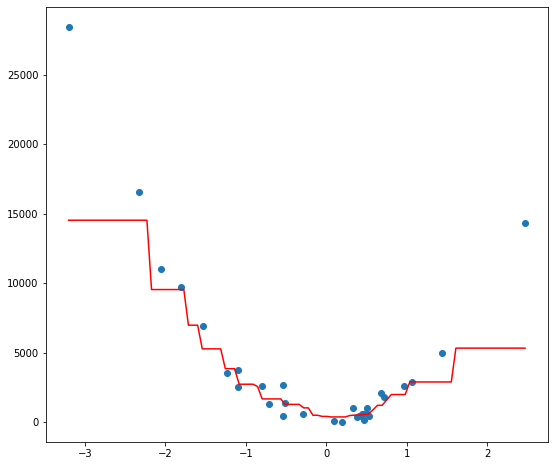

In [24]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5).fit(x,y)
plt.figure(figsize=(9, 8))
plt.scatter(x, y)
plt.plot(x_test ,model.predict(x_test), "r")
plt.show()

#### Perceptron
This is the most basic Artificial Neural Network https://en.wikipedia.org/wiki/Artificial_neural_network. Opposite  to the other models shown, this one is a "black box" and we cannot see how the algorithm calculates the output.

Don't worry if you get a warning when running this model.

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warnings.warn(


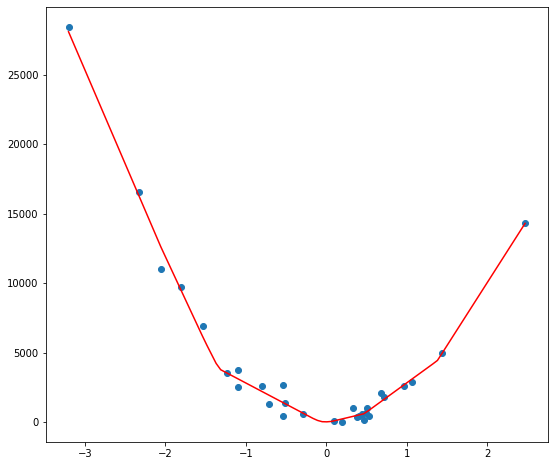

In [25]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(max_iter=50000).fit(x,y)
plt.figure(figsize=(9, 8))
plt.scatter(x, y)
plt.plot(x_test ,model.predict(x_test), "r")
plt.show()

### How to evaluate a regression model
We have trained 5 models, and we can guess that some are better than others, but we need a formal way to evaluate the models. There are several ways to evaluate a regression model, all of them based on the __error between the output of the model and the real answer__ when evaluating the test data, so the lower the error, the better the model. Let see some of them:

1. Max error: $max(| y_i - \hat{y}_i |)$

2. Mean absolute error or MAE: $\frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1} \left| y_i - \hat{y}_i \right|$

3. Mean squared error or MSE: $\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2$

Don't worry about the math, scikit learn will do everything for us!

Remember about K-Folds Cross Validation when evaluating the models.

In [73]:
from sklearn.metrics import  mean_absolute_error, mean_squared_error, max_error
models = {"Linear Regression":LinearRegression(), \
          "Decision Tree": DecisionTreeRegressor(), \
          "Random Forest": RandomForestRegressor(n_estimators=100), \
          "Nearest Neighbors": KNeighborsRegressor(n_neighbors=5), \
          "Perceptron": MLPRegressor(max_iter=2000)}

x, y = datasets.make_regression(n_samples=30, n_features=1, noise=10)

k = 3
kf = KFold(n_splits=k,shuffle=True)
for name in models:
    print("Start training models of {}".format(name))
    i = 0
    me_global = []
    mae_global = []
    mse_global = []
    for train, test in kf.split(x):
        i+=1
        x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]
        model = models[name].fit(x_train,y_train)
        y_out = model.predict(x_test)
        # We have to provide the real value of the target and the model's output
        me = max_error(y_test, y_out)
        mae = mean_absolute_error(y_test, y_out)
        mse = mean_squared_error(y_test, y_out)
        me_global.append(me)
        mae_global.append(mae)
        mse_global.append(mse)
        print("Iteration {}: me={:.4f} mae={:.4f} mse={:.4f}".format(i,me, mae, mse))
    print("Global: me={:.4f} mae={:.4f} mse={:.4f}\n".format(np.average(me_global), np.average(mae_global), np.average(mse_global)))

Start training models of Linear Regression
Iteration 1: me=17.4976 mae=6.8132 mse=72.6401
Iteration 2: me=22.1746 mae=8.4909 mse=120.7794
Iteration 3: me=20.6218 mae=8.8841 mse=109.5294
Global: me=20.0980 mae=8.0627 mse=100.9829

Start training models of Decision Tree
Iteration 1: me=30.3833 mae=10.3127 mse=187.2151
Iteration 2: me=20.1609 mae=9.3072 mse=123.3297
Iteration 3: me=18.4514 mae=6.4531 mse=63.1731
Global: me=22.9985 mae=8.6910 mse=124.5727

Start training models of Random Forest
Iteration 1: me=27.3056 mae=9.6719 mse=154.3336
Iteration 2: me=21.7875 mae=8.9983 mse=127.1925
Iteration 3: me=16.4537 mae=7.7614 mse=84.5795
Global: me=21.8489 mae=8.8105 mse=122.0352

Start training models of Nearest Neighbors
Iteration 1: me=36.7950 mae=15.3636 mse=352.2894
Iteration 2: me=20.4684 mae=11.0509 mse=155.1490
Iteration 3: me=14.1188 mae=6.1431 mse=59.6772
Global: me=23.7941 mae=10.8526 mse=189.0385

Start training models of Perceptron


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1: me=21.1134 mae=10.8424 mse=155.9084


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2: me=16.1485 mae=6.6795 mse=69.4924
Iteration 3: me=18.5566 mae=6.2282 mse=68.8254
Global: me=18.6062 mae=7.9167 mse=98.0754



/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


### Try it
Now is your turn to create a "real world" model. Just after reading the datasets, we have transformed and prepared them in a format suitable for the algorithms we have just seen.

The target is to predict the delay of a train arriving to the destination, that is the `delay_LLEGADA` column. We will use a vector of features that contains all the other columns in the train dataset. 

The task is to train some regression models using different algorithms and keep the best one. Then answer the following questions:

- What is the best algorithm?
- What measure have you used to select the best model?
- Do you think that the best model is a "good" regression model? Why?
- Can you think of a variable that we can add to our features to improve the result?

In [76]:
from sklearn.metrics import explained_variance_score

x = trains.drop("delay_LLEGADA", axis=1).values
y = trains["delay_LLEGADA"].values

models = {"Linear Regression":LinearRegression(), \
          "Decision Tree": DecisionTreeRegressor(), \
          "Random Forest": RandomForestRegressor(n_estimators=100), \
          "Nearest Neighbors": KNeighborsRegressor(n_neighbors=5), \
          "Perceptron": MLPRegressor(max_iter=2000)}

k = 3
kf = KFold(n_splits=k,shuffle=True)

evgs = {}

for name in models:
    i = 0
    me_global = []
    mae_global = []
    mse_global = []
    evg_global = []
    for train, test in kf.split(x):
        i+=1
        x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]
        model = models[name].fit(x_train,y_train)
        y_out = model.predict(x_test)
        # We have to provide the real value of the target and the model's output
        me = max_error(y_test, y_out)
        mae = mean_absolute_error(y_test, y_out)
        mse = mean_squared_error(y_test, y_out)
        evg = explained_variance_score(y_test, y_out)
        me_global.append(me)
        mae_global.append(mae)
        mse_global.append(mse)
        evg_global.append(evg)
    evgs[name] = np.average(evg_global)

print("1. What is the best algorithm?:")
best_algorithm = max(evgs, key=evgs.get)
print(f'{best_algorithm}, with a explained variance score of {evgs[best_algorithm]}')

print("2. What measure have you used to select the best model?:")
print("The explained variance score.")

1. What is the best algorithm?:
Linear Regression, with a explained variance score of 0.055969925854427914
2. What measure have you used to select the best model?:
The explained variance score.


In [77]:
print("3. Do you think that the best model is a 'good' regression model? Why?")
print("No, because it has a explained variance score of 0.056... that is really really low (best score is 1.0)")

3. Do you think that the best model is a 'good' regression model? Why?
No, because it has a explained variance score of 0.056... that is really really low (best score is 1.0)


## Classification
Another common task in ML is classification; in this case the target will be a class or a categorical variable, like in the iris dataset.

When talking about classifications task there are two possibilities: the target can only be positive or negative (binary classification) or the target can be any class of a set of categories (multi class).

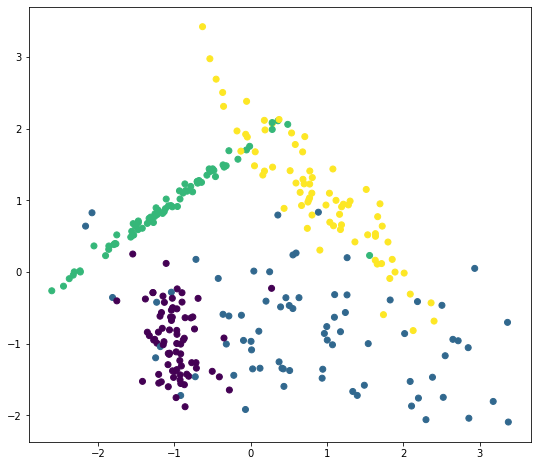

In [50]:
x, y = datasets.make_classification(n_samples=300, n_features=2,n_classes=4,n_redundant=0,n_clusters_per_class=1)
# try to modify the relation between x and y or play with the noise value
#y = y**2
#y = np.sin(y)
plt.figure(figsize=(9, 8))
plt.scatter(x[:,0], x[:,1],c=y)
plt.show()

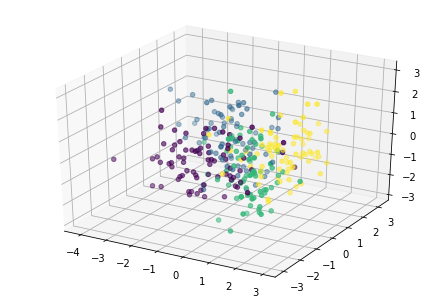

In [51]:
fig = plt.figure()
ax = Axes3D(fig)
x, y = datasets.make_classification(n_samples=300, n_features=3,n_classes=4,n_redundant=0,n_clusters_per_class=1)
ax.scatter(x[:,0], x[:,1], x[:,2],c=y)
plt.show()

### Some popular models
Like in the case of regression there are many algorithms for classification. Many of them have implementations for both regression and classification. 

In the following plots, the decision regions will be plotted. Those are the regions that the model will use to perform the classification, an input will be classified depending on which region it appears.

#### Logistic regression
Don't be misleading with the regression word, this model can only be used for classification.

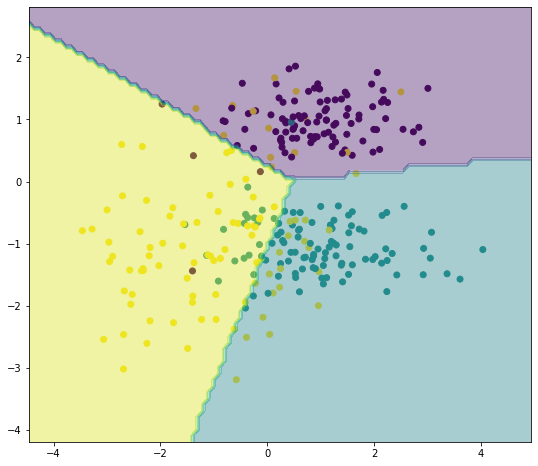

In [52]:
from sklearn.linear_model import LogisticRegression

x, y = datasets.make_classification(n_samples=300, n_features=2,n_classes=3,n_redundant=0,n_clusters_per_class=1)

# For decision regions
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

model = LogisticRegression(multi_class="auto", solver="lbfgs").fit(x,y)
plt.figure(figsize=(9, 8))
plt.scatter(x[:,0], x[:,1],c=y)

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.show()

#### Decision Tree

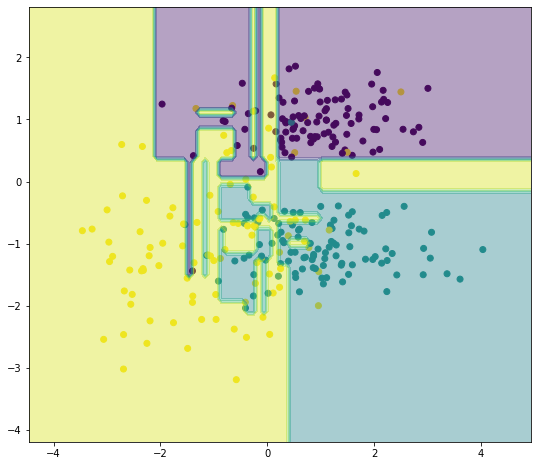

In [53]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier().fit(x,y)
plt.figure(figsize=(9, 8))
plt.scatter(x[:,0], x[:,1],c=y)

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.show()

#### Random Forest

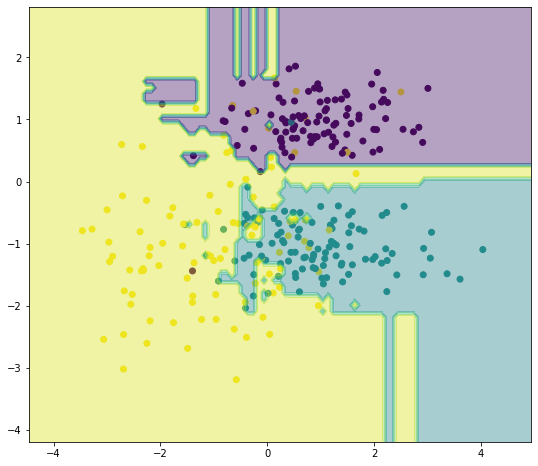

In [54]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100).fit(x,y)
plt.figure(figsize=(9, 8))
plt.scatter(x[:,0], x[:,1],c=y)

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.show()

#### K Nearest Neighbors

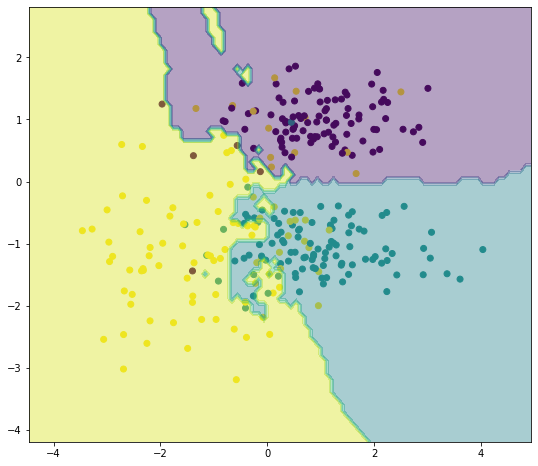

In [55]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5).fit(x,y)
plt.figure(figsize=(9, 8))
plt.scatter(x[:,0], x[:,1],c=y)

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.show()

#### Perceptron

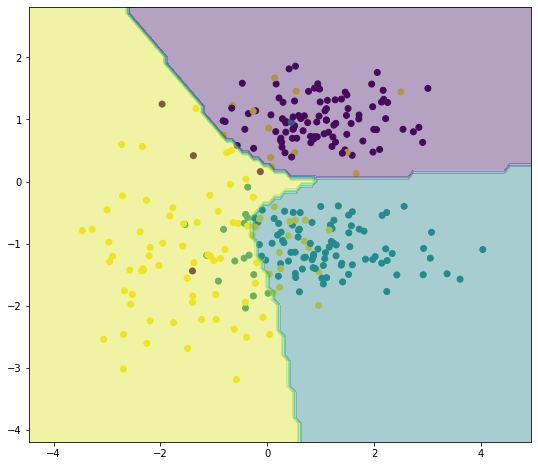

In [56]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(max_iter=2000).fit(x,y)
plt.figure(figsize=(9, 8))
plt.scatter(x[:,0], x[:,1],c=y)

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.show()

### How to evaluate a classification model
In this case the output is a class or a label, so we can't calculate the error, instead we will calculate a ratio between the number of times that the output is correct and another count of the outputs, the total number or the number of wrong outputs for example. For example, the most intuitive way to evaluate a classification model is the accuracy : How many times my model guess the correct answer over all the anwsers?. But, even if this can be useful in some cases, in practice, it is not an informative measure.

### Confusion matrix
This is the main tool for evaluating a classification model https://en.wikipedia.org/wiki/Confusion_matrix. It is defined as:

"By definition a confusion matrix $C$ is such that $C_{i,j}$ is equal to the number of observations known to be in group $i$ but predicted to be in group $j$."

In other words, it is a matrix where columns represent the true class and rows represent the output class. With it we can know how many samples have been correctly classified and which classes can be confused.


In the case of binary classification, the matrix has only 2 columns and 2 rows, and each of the cells has a proper name.

There are some metrics obtained from these cells:
1. Precision: the ratio between positive predicted and the total of positive samples $\frac{TP}{TP+FP}$
2. Accuracy: the ratio of correctly predicted over the total of samples $\frac{TP+TN}{TP+FP+TN+FN}$
3. Recall: the ratio of correctly predicted over all predicted as positive $\frac{TP}{TP+FN}$
4. F1 score: harmonic mean of precision and recall $\frac{Precision*Recall}{Precision+Recall}=\frac{2*TP}{2*TP+FP+FN}$

Usually more complex metrics are used, but for this course the F1 score is enough. And again, don't worry, scikit learn includes all these calculations.

In [78]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

models = {"Logistic Regression":LogisticRegression(multi_class="auto", solver="lbfgs", max_iter=2000), \
          "Decision Tree": DecisionTreeClassifier(), \
          "Random Forest": RandomForestClassifier(n_estimators=100), \
          "Nearest Neighbors": KNeighborsClassifier(n_neighbors=5), \
          "Perceptron": MLPClassifier(max_iter=2000)}

x, y = datasets.make_classification(n_samples=300)

for name in models:
    print("Start training models of {}".format(name))
    i = 0
    f1_global = []
    for train, test in kf.split(x):
        i+=1
        x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]
        model = models[name].fit(x_train,y_train)
        y_out = model.predict(x_test)
        # We have to provide the real value of the target and the model's output
        f1_global.append(f1_score(y_test, y_out, average="weighted"))
        print(confusion_matrix(y_test, y_out))
        print(classification_report(y_test, y_out))
    print("Global: f1={:.4f}\n".format(np.average(f1_global)))

Start training models of Logistic Regression
[[47  0]
 [ 0 53]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        53

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

[[55  0]
 [ 4 41]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        55
           1       1.00      0.91      0.95        45

    accuracy                           0.96       100
   macro avg       0.97      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100

[[48  0]
 [ 1 51]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        48
           1       1.00      0.98      0.99        52

    accuracy                           0.99       100
   macro avg       0.99   

### Try it
In this case, although we will use the same dataframe, our target is to know which client created the logistics order. As in the case of regression, we will use the rest of the columns as features of the model. Find which model works better with this data and answer the following questions:

- What is the best algorithm?
- What is the average F1 score for that algorithm?
- Which type of client is the most difficult to classify? And the easiest? 
- Which client is most often confused by CLIENT_0? • Which client is usually misclassified as CLIENT_0?


In [88]:
x = trains.drop("client", axis=1).values
y = trains["client"].values

models = {"Logistic Regression":LogisticRegression(multi_class="auto", solver="lbfgs", max_iter=2000), \
          "Decision Tree": DecisionTreeClassifier(), \
          "Random Forest": RandomForestClassifier(n_estimators=100), \
          "Nearest Neighbors": KNeighborsClassifier(n_neighbors=5), \
          "Perceptron": MLPClassifier(max_iter=2000)}

f1s = {}

for name in models:
    i = 0
    f1_global = []
    for train, test in kf.split(x):
        i+=1
        x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]
        model = models[name].fit(x_train,y_train)
        y_out = model.predict(x_test)
        # We have to provide the real value of the target and the model's output
        f1_global.append(f1_score(y_test, y_out, average="weighted"))
    f1s[name] = np.average(f1_global)

print(f1s)
print("1. What is the best algorithm?:")
best_algorithm = max(f1s, key=f1s.get)
print(best_algorithm)
print("2. What is the average F1 score for that algorithm?:")
print(f1s[best_algorithm])

{'Logistic Regression': 0.48885816161289736, 'Decision Tree': 0.7856540135839231, 'Random Forest': 0.8140767128140274, 'Nearest Neighbors': 0.6710723508754614, 'Perceptron': 0.5175893012185815}
1. What is the best algorithm?:
Random Forest
2. What is the average F1 score for that algorithm?:
0.8140767128140274


In [92]:
f1s = {}

for client_id in [0, 1, 2, 3]:
  f1_global = []
  for train, test in kf.split(x):
      x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]
      model = models["Random Forest"].fit(x_train,y_train)
      y_out = model.predict(x_test)
      f1_global.append(f1_score(y_test, y_out, average="weighted", labels=[client_id]))
  f1s[client_id] = np.average(f1_global)

print("3. Which type of client is the most difficult to classify? And the easiest?")
print(f'The most difficult one is CLIENT {min(f1s, key=f1s.get)} and the easiest one is CLIENT {max(f1s, key=f1s.get)}')

{0: 0.6157838840156779, 1: 0.8255899119323696, 2: 0.9992509363295881, 3: 0.43869834556468706}
3. Which type of client is the most difficult to classify? And the easiest?
The most difficult one is CLIENT 3 and the easiest one is CLIENT 2
